In [2]:
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths
audio_features_path = "/content/audio_features.npy"
audio_labels_path = "/content/audio_labels.npy"
gait_features_path = "/content/drive/MyDrive/gait_feature_vectors_rf.npy"

# Load the feature vectors
audio_features = np.load(audio_features_path)
audio_labels = np.load(audio_labels_path)
gait_features = np.load(gait_features_path)

# Print shapes to verify
print("Audio Features Shape:", audio_features.shape)
print("Audio Labels Shape:", audio_labels.shape)
print("Gait Features Shape:", gait_features.shape)


Mounted at /content/drive
Audio Features Shape: (81, 128)
Audio Labels Shape: (81,)
Gait Features Shape: (2485, 100)


Step 2: Normalize Gait Features

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Convert gait features to float32
gait_features = gait_features.astype(np.float32)

# Apply Min-Max Scaling
scaler = MinMaxScaler()
gait_features_normalized = scaler.fit_transform(gait_features)

# Print stats to verify normalization
print("Gait Features (After Normalization):")
print("Min:", gait_features_normalized.min())
print("Max:", gait_features_normalized.max())
print("Mean:", gait_features_normalized.mean())
print("Std Dev:", gait_features_normalized.std())

# Save the normalized gait features
normalized_gait_path = "/content/drive/MyDrive/gait_features_normalized.npy"
np.save(normalized_gait_path, gait_features_normalized)

print(f"Normalized gait features saved to: {normalized_gait_path}")


Gait Features (After Normalization):
Min: 0.0
Max: 1.0000001
Mean: 0.5044536
Std Dev: 0.3082651
Normalized gait features saved to: /content/drive/MyDrive/gait_features_normalized.npy


Step 3: Align Data Dimensions
Your datasets have different sample sizes:

Audio Features → (81, 128)

Gait Features → (2485, 100)

In [4]:
import numpy as np

# Define the target number of samples (match audio features)
target_samples = audio_features.shape[0]  # 81 samples

# Compute segment size for downsampling
segment_size = gait_features_normalized.shape[0] // target_samples  # Divide total gait samples by target

# Downsample by averaging consecutive segments
downsampled_gait_features = np.array([
    np.mean(gait_features_normalized[i * segment_size: (i + 1) * segment_size], axis=0)
    for i in range(target_samples)
])

# Print new shape
print("Downsampled Gait Features Shape:", downsampled_gait_features.shape)  # Expected (81, 100)

# Save downsampled gait features
downsampled_gait_path = "/content/drive/MyDrive/gait_features_downsampled.npy"
np.save(downsampled_gait_path, downsampled_gait_features)

print(f"Downsampled gait features saved to: {downsampled_gait_path}")


Downsampled Gait Features Shape: (81, 100)
Downsampled gait features saved to: /content/drive/MyDrive/gait_features_downsampled.npy



Step 4: Multimodal Fusion Preparation

Code to Merge Audio & Gait Features

In [5]:
# Load downsampled gait features
downsampled_gait_features = np.load("/content/drive/MyDrive/gait_features_downsampled.npy")

# Concatenate along the feature axis
multimodal_features = np.concatenate((audio_features, downsampled_gait_features), axis=1)  # Shape: (81, 228)

# Print final shape
print("Multimodal Features Shape:", multimodal_features.shape)  # Expected: (81, 228)

# Save the final multimodal feature set
multimodal_features_path = "/content/drive/MyDrive/multimodal_features.npy"
np.save(multimodal_features_path, multimodal_features)

print(f"Multimodal features saved to: {multimodal_features_path}")


Multimodal Features Shape: (81, 228)
Multimodal features saved to: /content/drive/MyDrive/multimodal_features.npy


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

# Load data
X = np.load("/content/drive/MyDrive/multimodal_features.npy")
y = np.load("/content/audio_labels.npy")  # Labels

# Split into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape input for CNN-LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (81, 1, 228)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])      # (20, 1, 228)

# Build the CNN-LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(1, 228)),
    BatchNormalization(),
    MaxPooling1D(pool_size=1),

    LSTM(64, return_sequences=True),
    LSTM(32),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model.save("/content/drive/MyDrive/multimodal_cnn_lstm_model.h5")
print("Model saved successfully!")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.7001 - loss: 0.6790 - val_accuracy: 0.8235 - val_loss: 0.6798
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8058 - loss: 0.6504 - val_accuracy: 0.8824 - val_loss: 0.6531
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7764 - loss: 0.6219 - val_accuracy: 0.8824 - val_loss: 0.6165
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8899 - loss: 0.5610 - val_accuracy: 0.8235 - val_loss: 0.5607
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9070 - loss: 0.4654 - val_accuracy: 0.8824 - val_loss: 0.4774
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8071 - loss: 0.4666 - val_accuracy: 0.7647 - val_loss: 0.4399
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8491 - loss: 0.3842 - val_accuracy: 0.7647 - val_loss: 0.3757
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9254 - loss: 0.2860 - val_accuracy: 0.7647 - val_loss: 0.3501
Epoch 9/10

Test Accuracy: 0.8824
Model saved successfully!


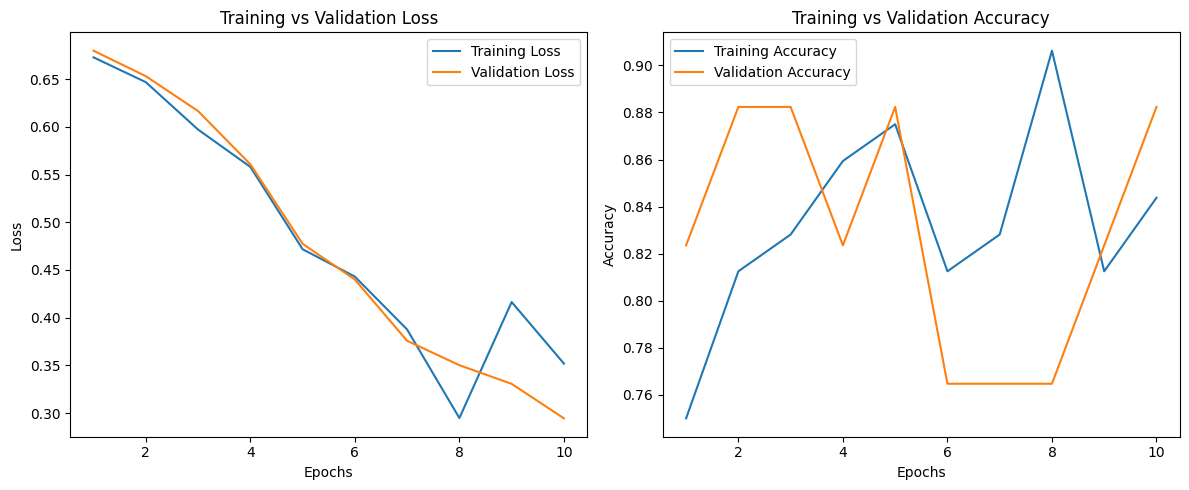

In [11]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


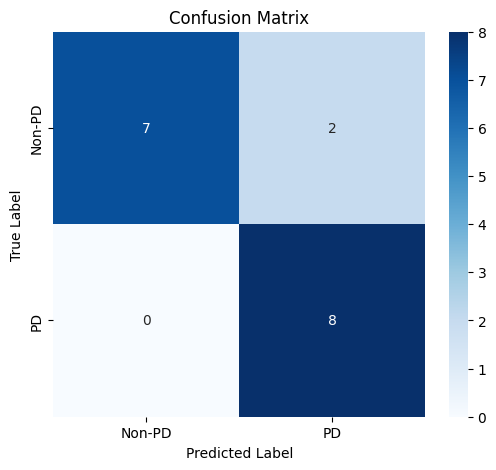

Classification Report:
               precision    recall  f1-score   support

      Non-PD       1.00      0.78      0.88         9
          PD       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-PD", "PD"], yticklabels=["Non-PD", "PD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Non-PD", "PD"]))


In [27]:
# Generate a random test feature vector (assuming 228 features)
new_patient_data = np.random.rand(1, 228).astype(np.float32)

# Save it for testing
np.save("/content/drive/MyDrive/new_patient_multimodal.npy", new_patient_data)
print("Test file created successfully!")


Test file created successfully!


In [28]:
import numpy as np

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/multimodal_cnn_lstm_model.h5")

# Load a new patient’s multimodal feature vector (must be preprocessed & same shape as training data)
new_patient_data = np.load("/content/drive/MyDrive/new_patient_multimodal.npy")  # Shape: (1, 228)

# Reshape to match model input
new_patient_data = new_patient_data.reshape(1, 1, 228)  # (1 sample, 1 timestep, 228 features)

# Make prediction
prediction = model.predict(new_patient_data)

# Interpret the result
predicted_label = "Parkinson’s Detected" if prediction > 0.5 else "No Parkinson’s"
confidence = prediction[0][0] * 100  # Convert probability to percentage

print(f"Prediction: {predicted_label} (Confidence: {confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Prediction: Parkinson’s Detected (Confidence: 56.90%)


Train multimodal using RF

Test Accuracy: 0.8824

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.75      0.86         8

    accuracy                           0.88        17
   macro avg       0.91      0.88      0.88        17
weighted avg       0.90      0.88      0.88        17

Model saved at /content/drive/MyDrive/multimodal_rf_model.pkl


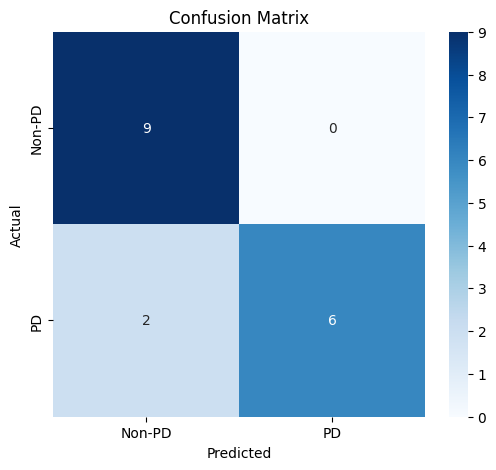

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
X = np.load("/content/drive/MyDrive/multimodal_features.npy")  # (81, 228)
y = np.load("/content/audio_labels.npy")  # (81,)

# Split into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save the model
model_path = "/content/drive/MyDrive/multimodal_rf_model.pkl"
joblib.dump(rf_model, model_path)
print(f"Model saved at {model_path}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-PD", "PD"], yticklabels=["Non-PD", "PD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


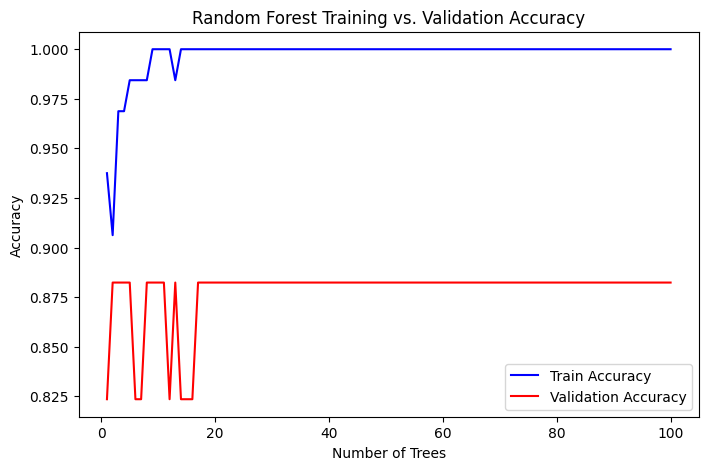

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Get the number of trees
n_trees = len(rf_model.estimators_)

# Calculate training accuracy per tree
train_acc = []
test_acc = []

for i in range(1, n_trees + 1):
    partial_rf = RandomForestClassifier(n_estimators=i, random_state=42)
    partial_rf.fit(X_train, y_train)

    # Store accuracy for each number of trees
    train_acc.append(partial_rf.score(X_train, y_train))
    test_acc.append(partial_rf.score(X_test, y_test))

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_trees + 1), train_acc, label="Train Accuracy", color='blue')
plt.plot(range(1, n_trees + 1), test_acc, label="Validation Accuracy", color='red')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Random Forest Training vs. Validation Accuracy")
plt.legend()
plt.show()


In [29]:
# Load test patient data
new_patient_data = np.load("/content/drive/MyDrive/new_patient_multimodal.npy")  # Shape: (1, 228)

# Make prediction
new_prediction = rf_model.predict(new_patient_data)

# Interpret result
predicted_label = "Parkinson’s Detected" if new_prediction[0] == 1 else "No Parkinson’s"
print(f"🧑‍⚕️ Prediction for New Patient: {predicted_label}")


🧑‍⚕️ Prediction for New Patient: No Parkinson’s


In [25]:
import numpy as np

# Assuming the real patient had Parkinson’s (change 1 to 0 if they didn't)
true_label = np.array([1])  # 1 = Parkinson’s, 0 = No Parkinson’s

# Save the true label for future use
np.save("/content/drive/MyDrive/new_patient_label.npy", true_label)

print("✅ True label saved successfully!")


✅ True label saved successfully!


In [30]:
# Load new patient data
new_patient_data = np.load("/content/drive/MyDrive/new_patient_multimodal.npy")  # Shape: (1, 228)

# Load the true label (assuming it's stored separately)
true_label = np.load("/content/drive/MyDrive/new_patient_label.npy")  # (1,)

# Make prediction using Random Forest
predicted_label = rf_model.predict(new_patient_data)[0]

# Interpret the results
label_map = {0: "No Parkinson’s", 1: "Parkinson’s"}
actual_label_text = label_map[true_label[0]]
predicted_label_text = label_map[predicted_label]

# Print results
print(f"🩺 **Actual Diagnosis (Ground Truth):** {actual_label_text}")
print(f"🔮 **Model Prediction:** {predicted_label_text}")

# Check if the prediction was correct
if predicted_label == true_label[0]:
    print("✅ **Prediction is Correct!**")
else:
    print("❌ **Prediction is Incorrect!**")


🩺 **Actual Diagnosis (Ground Truth):** Parkinson’s
🔮 **Model Prediction:** No Parkinson’s
❌ **Prediction is Incorrect!**


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
📌 CNN-LSTM Accuracy: 0.8824
📌 Random Forest Accuracy: 0.8824

🔹 CNN-LSTM Classification Report:
               precision    recall  f1-score   support

      Non-PD       1.00      0.78      0.88         9
          PD       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17


🔹 Random Forest Classification Report:
               precision    recall  f1-score   support

      Non-PD       0.82      1.00      0.90         9
          PD       1.00      0.75      0.86         8

    accuracy                           0.88        17
   macro avg       0.91      0.88      0.88        17
weighted avg       0.90      0.88      0.88        17



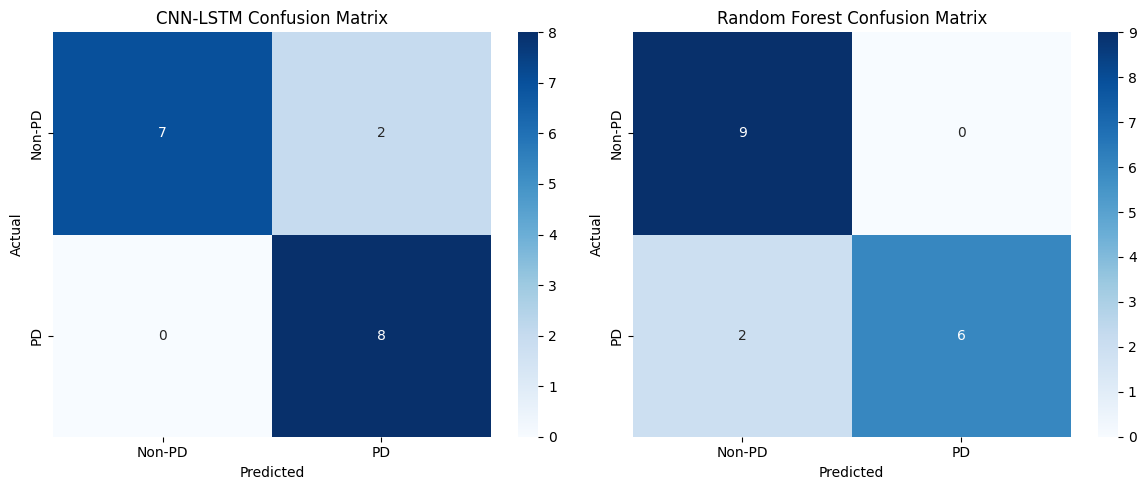

In [18]:
import joblib
import tensorflow as tf

# Load CNN-LSTM Model
cnn_lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/multimodal_cnn_lstm_model.h5")

# Load Random Forest Model
rf_model = joblib.load("/content/drive/MyDrive/multimodal_rf_model.pkl")

# Predict using CNN-LSTM
cnn_lstm_preds = (cnn_lstm_model.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1])) > 0.5).astype("int32")

# Predict using Random Forest
rf_preds = rf_model.predict(X_test)

# Print Accuracy Scores
from sklearn.metrics import accuracy_score

cnn_lstm_acc = accuracy_score(y_test, cnn_lstm_preds)
rf_acc = accuracy_score(y_test, rf_preds)

print(f"📌 CNN-LSTM Accuracy: {cnn_lstm_acc:.4f}")
print(f"📌 Random Forest Accuracy: {rf_acc:.4f}")

# Print Classification Reports
from sklearn.metrics import classification_report

print("\n🔹 CNN-LSTM Classification Report:\n", classification_report(y_test, cnn_lstm_preds, target_names=["Non-PD", "PD"]))
print("\n🔹 Random Forest Classification Report:\n", classification_report(y_test, rf_preds, target_names=["Non-PD", "PD"]))

# Plot Confusion Matrices
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CNN-LSTM Confusion Matrix
cm_cnn = confusion_matrix(y_test, cnn_lstm_preds)
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-PD", "PD"], yticklabels=["Non-PD", "PD"], ax=axes[0])
axes[0].set_title("CNN-LSTM Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-PD", "PD"], yticklabels=["Non-PD", "PD"], ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
